# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

device = torch.device('cpu')
# training on GPU in not awailable right now

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
#             print(type(array))
        
        array = array.reshape(1, self.height,self.width)

#         print(type(array))
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
# transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=1),
#         transforms.RandomRotation(degrees=45),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomGrayscale(p=0.1)
#     ]),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]) normalize images
# ])

# color_transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=0.4),
#         transforms.ColorJitter(brightness=0.5),
#         transforms.ColorJitter(brightness=0.6),
#         transforms.ColorJitter(brightness=0.7)
#     ]),
#     transforms.ToTensor()
# ])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations)
#           BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations)
print(dataset)

683, 76


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


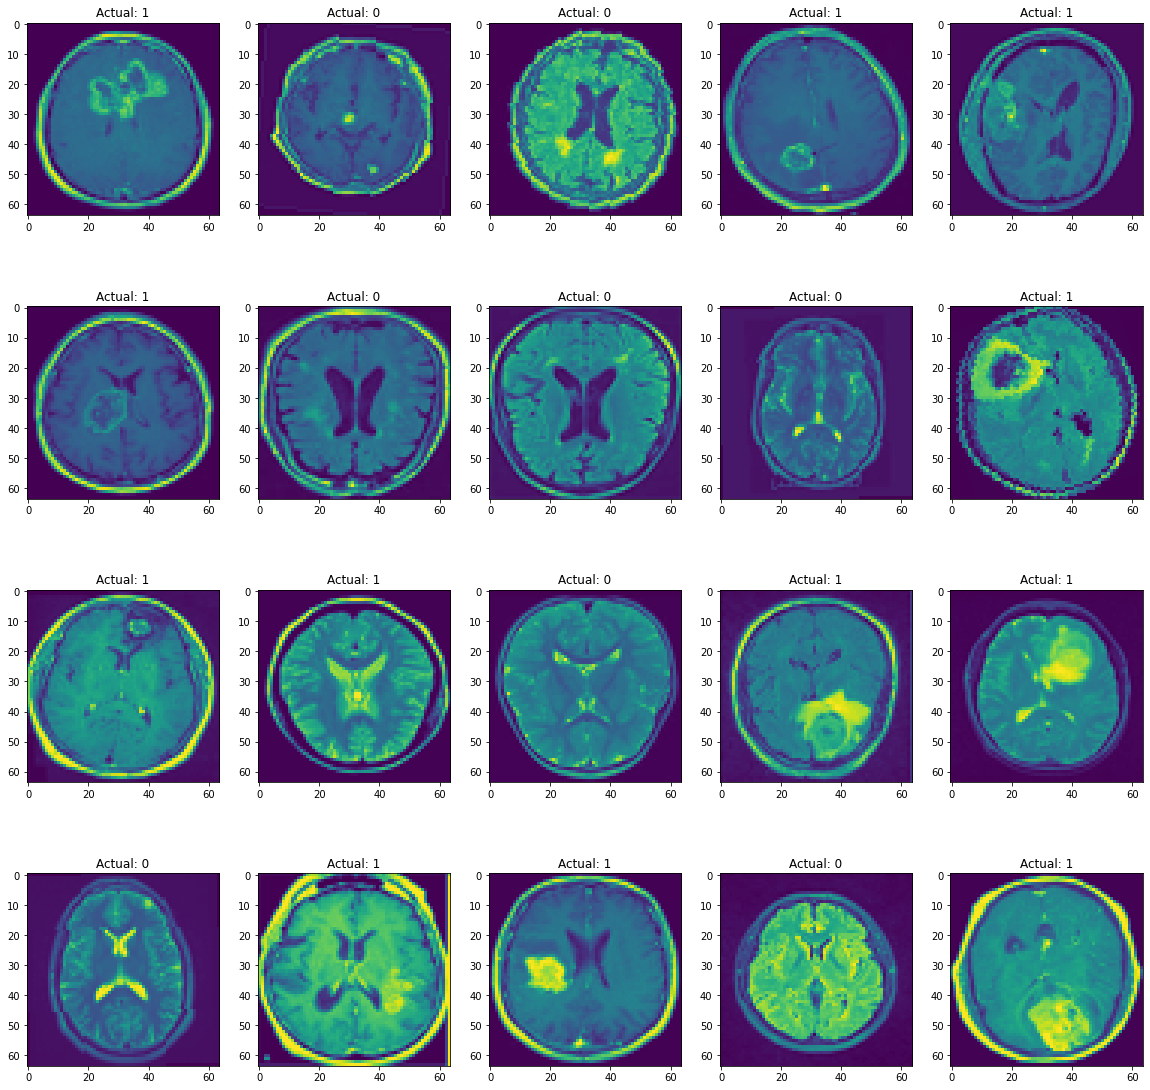

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.9)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [6]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [7]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
plot = False

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i} Test Loss: {test_loss}, Accuracy: {accuracy}')
#             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

In [9]:
loss_list = train(model, train_data, test_data, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss: 1.7361928224563599 Test Loss: 0.7249147891998291, Accuracy: 0.5659722089767456
Epochs: 10 Loss: 0.3360118567943573 Test Loss: 1.2186847726504009, Accuracy: 0.7048611044883728
Epochs: 20 Loss: 0.2547204792499542 Test Loss: 1.5755927960077922, Accuracy: 0.7256944179534912
Epochs: 30 Loss: 0.1233651340007782 Test Loss: 1.7544022301832836, Accuracy: 0.8055555820465088
Epochs: 40 Loss: 0.050708137452602386 Test Loss: 2.002809385458628, Accuracy: 0.8055555820465088
Epochs: 50 Loss: 0.17110773921012878 Test Loss: 0.8908278346061707, Accuracy: 0.7777777314186096
Epochs: 60 Loss: 0.020298952236771584 Test Loss: 2.0687650640805564, Accuracy: 0.7569444179534912
Epochs: 70 Loss: 0.030367190018296242 Test Loss: 2.2921317418416343, Accuracy: 0.7951388955116272
Epochs: 80 Loss: 0.010624468326568604 Test Loss: 2.551898241043091, Accuracy: 0.8229166865348816
Epochs: 90 Loss: 0.01817253977060318 Test Loss: 2.671970844268799, Accuracy: 0.8229166865348816
Epochs: 100 Loss: 0.00647586118429

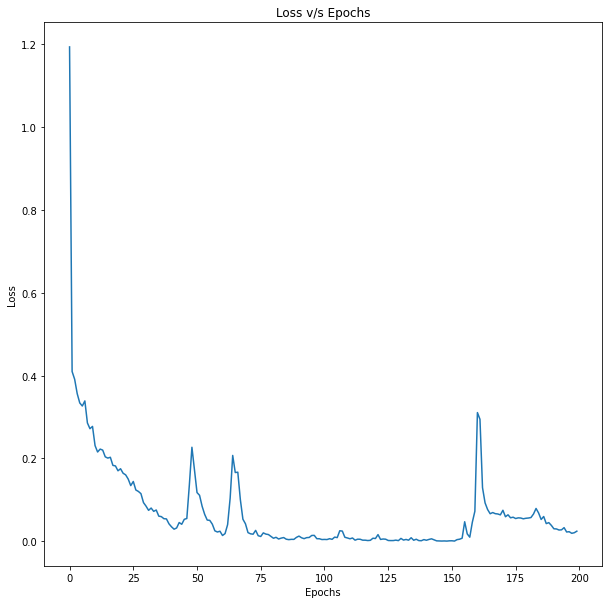

In [11]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [12]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n'
          f'Test Loss: {test_loss/number_of_imags: .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
test(model, test_loader, loss_fn)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.84 
Test Loss:  1.56


(4.665249466896057, tensor(2.5208))

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


tensor([[-9.6306,  9.8449]], grad_fn=<AddmmBackward>)
tensor([[-0.6256,  0.6204]], grad_fn=<AddmmBackward>)
tensor([[ 3.5575, -3.5268]], grad_fn=<AddmmBackward>)
tensor([[ 14.0550, -13.9959]], grad_fn=<AddmmBackward>)
tensor([[-13.4437,  13.5171]], grad_fn=<AddmmBackward>)
tensor([[ 11.5930, -11.9976]], grad_fn=<AddmmBackward>)
tensor([[-8.4302,  8.5248]], grad_fn=<AddmmBackward>)
tensor([[-7.3118,  7.7559]], grad_fn=<AddmmBackward>)
tensor([[ 17.6348, -17.8241]], grad_fn=<AddmmBackward>)
tensor([[ 2.0061, -1.6582]], grad_fn=<AddmmBackward>)
tensor([[-0.4394,  2.2636]], grad_fn=<AddmmBackward>)
tensor([[-13.9664,  15.1087]], grad_fn=<AddmmBackward>)
tensor([[-8.9909,  9.2021]], grad_fn=<AddmmBackward>)
tensor([[-5.3500,  5.2713]], grad_fn=<AddmmBackward>)
tensor([[-7.7737,  8.0827]], grad_fn=<AddmmBackward>)
tensor([[-8.0198,  8.0989]], grad_fn=<AddmmBackward>)
tensor([[-14.6439,  14.7657]], grad_fn=<AddmmBackward>)
tensor([[-7.0004,  6.8409]], grad_fn=<AddmmBackward>)
tensor([[-9.0535

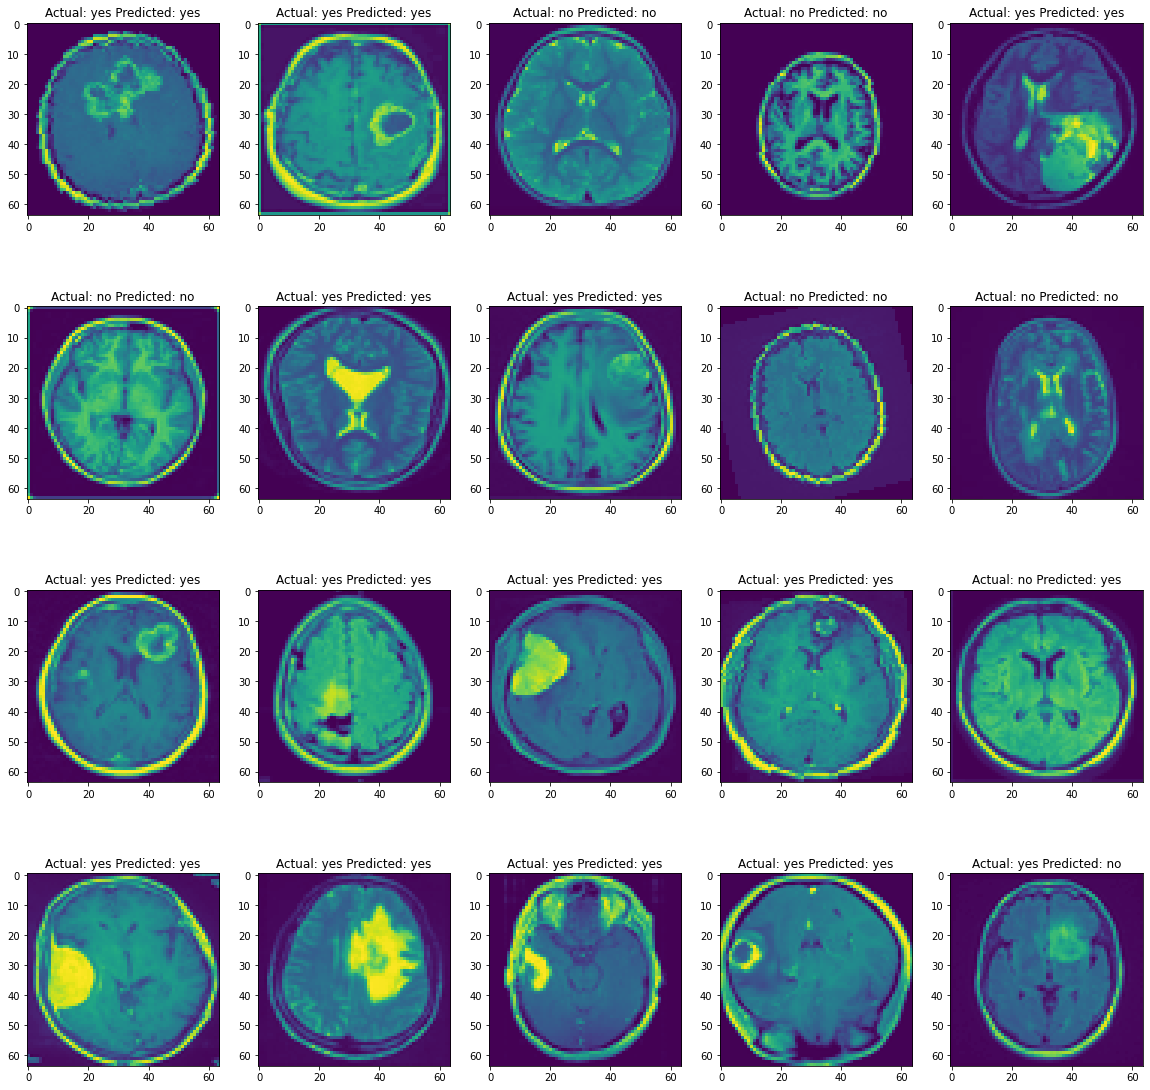

actual accuracy:  0.90


In [14]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

### SyMPC part


In [15]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [16]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

    split_size = int(len(data)/len(session.parties))+1

    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        image_pointers.append(ptr)

    return image_pointers

In [17]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [18]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)
    if i == 10: break
ptrs


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,


In [17]:
# advanced split data
imgs, lbls = next(iter(test_loader))
a_ptrs = split_send(imgs, session=session)

a_ptrs


<ipython-input-2-c1a3fe28dd34>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array, device=device)


[[MPCTensor]
 Shape: torch.Size([17, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([15, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]

In [19]:
mpc_model = model.share(session)
mpc_model

In [20]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2021-11-18T11:06:51.319033+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2077b5935c443fd890750b82bfabef9>.
[2021-11-18T11:06:51.326965+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36e321f7bde0455a805f63eb97c15c22>.
[2021-11-18T11:07:59.574249+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41c32b3b5af94a34bf764384a060f68b>.
[2021-11-18T11:07:59.584759+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f545b4de534f489cbfc68778ba0460c6>.
[2021-11-18T11:08:34.787180+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb5008b9b968477cbee37983c142bad1>.
[2021-11-18T11:08:34.790302+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2c622d38cc74665874f2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-21.2252,  21.6360]])


[2021-11-18T11:08:45.484613+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dc9d7bd1feb401f8bf47064b6f27c4e>.
[2021-11-18T11:08:45.490349+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7c9756cb9a84d2e8370cfd889bb5cd6>.
[2021-11-18T11:08:45.502042+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6fd1bbd82dbb41fa9c186c716cd3710b>.
[2021-11-18T11:08:45.512477+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e42751247324fd58724db05ac7acc2f>.
[2021-11-18T11:08:45.521191+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73372d593f5f4088a822d425d92b015c>.
[2021-11-18T11:08:45.523606+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36da771373254d22b0752

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-980.7882,  997.1919]])


[2021-11-18T11:10:36.776472+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44a4c5c0b7e04924a97c74150a4a9f63>.
[2021-11-18T11:10:36.784465+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea54db846c5347f5b1d3c7fdfdc77f9a>.
[2021-11-18T11:10:36.796873+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14ad09d524714169a89aa9ead2937f39>.
[2021-11-18T11:10:36.805777+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a16453213444ba3ae89100eef3c5aaa>.
[2021-11-18T11:10:36.820176+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bffb2c1e414a42cfa32dc7d65ecf88c5>.
[2021-11-18T11:10:36.822908+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f23357649cc4209bbb39

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.5218, -2.4613]])


[2021-11-18T11:12:28.525373+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 890917069fd546e3b5137ea00d6d6c22>.
[2021-11-18T11:12:28.532110+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3321991cf1814bcab1c688ea9eb6582b>.
[2021-11-18T11:12:28.785501+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04451f79271344dd9956978d19bd92bb>.
[2021-11-18T11:12:28.794315+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4c3b2f825c64111badf90ff0d27a7c2>.
[2021-11-18T11:13:35.724516+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b19a889ab8164709aee09c674679bab2>.
[2021-11-18T11:13:35.732807+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fbf342ea5be549c594ddd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 36.8721, -37.7611]])


[2021-11-18T11:14:20.363170+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8aed65474dcb43b58a5e2b7799f6905a>.
[2021-11-18T11:14:20.368808+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e3b61920c87410386220a1f9d45b1a2>.
[2021-11-18T11:14:20.379825+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7736e92e7d73419baa1a4d70c938263b>.
[2021-11-18T11:14:20.387167+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e945db90004b48b4bbe28583e2060fe8>.
[2021-11-18T11:14:20.399351+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a374d6ec52145b8a634219a3d06a666>.
[2021-11-18T11:14:20.401816+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b93d04b5751c41bfa4e3d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-19.6868,  20.1558]])


[2021-11-18T11:16:10.780360+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54b3f750d24f4a3096dc1361ff3519ee>.
[2021-11-18T11:16:10.787833+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 483b8c0054014e65b42e7fe2b1e5715c>.
[2021-11-18T11:16:10.802430+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da8dd5ca42f540e4ad135c9b90d35ad2>.
[2021-11-18T11:16:10.811823+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71fbc07f420046a49b99ce04d721222f>.
[2021-11-18T11:16:10.825942+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 201d2e9dbb3446b2bab671c1c8a7af0d>.
[2021-11-18T11:16:10.828675+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c87a7561e9c4f2793185

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1612.6801, -1687.5898]])


[2021-11-18T11:18:04.536318+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4960e2227fa444eea031c5996c15ba72>.
[2021-11-18T11:18:04.542444+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f93cb0b2ddb247008c247aaa2d7aa6a6>.
[2021-11-18T11:18:04.777499+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 390a3cef6a7a4c67a8bbd3b7f428aacd>.
[2021-11-18T11:18:04.785314+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fc33691730e49e194f71c522db222c7>.
[2021-11-18T11:19:12.717407+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5161258abc44accbea5dd54c27eab1c>.
[2021-11-18T11:19:12.724215+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2aebcba50a35423080685

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-11.8496,  11.9734]])


[2021-11-18T11:19:56.723917+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ddc48ac43b14ba08e9aef4df224de71>.
[2021-11-18T11:19:56.730037+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c0d920f08d348ad90a7a89b734f7083>.
[2021-11-18T11:19:56.743785+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 86b55a98840548e887c996271942fb38>.
[2021-11-18T11:19:56.752096+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ea6687a368b43ca83462d3e8a7c85ea>.
[2021-11-18T11:19:56.765255+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d47cc7c04e34740904641b044615377>.
[2021-11-18T11:19:56.767892+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9dd4f8fdb4af479ba30df

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1381.1846, -1371.0850]])


[2021-11-18T11:21:47.880687+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e45c4f32a92b418685e13ae129fe6828>.
[2021-11-18T11:21:47.886780+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95bab51e93d445f4ac4edd078e2d1868>.
[2021-11-18T11:21:47.898758+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7983089d1514a52a44b7dc71135c103>.
[2021-11-18T11:21:47.906366+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 605a6ef5d425460b9eeaab6580388a10>.
[2021-11-18T11:21:47.918575+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc93191ca17a413193e1781cc676bec7>.
[2021-11-18T11:21:47.921468+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2af9f63e44024afcbcbf0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 18.5278, -18.6369]])


[2021-11-18T11:23:37.565982+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 770f49da85ce4ce980bd3a3fb32e1060>.
[2021-11-18T11:23:37.572358+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 851bdce4e58b49858e64cbef50dae820>.
[2021-11-18T11:23:37.590841+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5794a22cba6a43f99c12ce7817459c6a>.
[2021-11-18T11:23:37.594065+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6755b41fb72468b8f0d588cd1acfe4c>.
[2021-11-18T11:24:44.177022+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d19d46ed0eb948d7b3dda78da136971b>.
[2021-11-18T11:24:44.184173+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b676940ab4f743c7a9b8b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-211.2085,  204.7706]])


[2021-11-18T11:25:28.813409+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6d1e7063e4b4010871247f52d69c079>.
[2021-11-18T11:25:28.820089+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 841006a54c7847da93400293f8ed60e4>.
[2021-11-18T11:25:28.836814+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6cdae2e9ddb4ef59130493480946dbb>.
[2021-11-18T11:25:28.843839+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2478503ccb943e7952072217ef284c6>.
[2021-11-18T11:25:28.862311+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a74193b6df5425fa659ca9b9042f31e>.
[2021-11-18T11:25:28.865399+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 091a896855c14e2a9bff2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 366.3358, -381.5657]])


[tensor([[-21.2252,  21.6360]]),
 tensor([[-980.7882,  997.1919]]),
 tensor([[ 2.5218, -2.4613]]),
 tensor([[ 36.8721, -37.7611]]),
 tensor([[-19.6868,  20.1558]]),
 tensor([[ 1612.6801, -1687.5898]]),
 tensor([[-11.8496,  11.9734]]),
 tensor([[ 1381.1846, -1371.0850]]),
 tensor([[ 18.5278, -18.6369]]),
 tensor([[-211.2085,  204.7706]]),
 tensor([[ 366.3358, -381.5657]])]

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)
[2021-11-18T11:27:20.692079+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac5dd7a8a44b4b07927265e657bc00b9>.
[2021-11-18T11:27:20.694903+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2990c841b8ca4b0a83e369f3f5552242>.
[2021-11-18T11:27:20.701021+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f33e6b436a74b31a4859e9b2026884b>.
[2021-11-18T11:27:20.703794+0000][CRITICAL][logger]][5295] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0170b1516c9427eb4ccbe9acec6e9ca>.
[2021-11-18T11:27:20.713491+0000][CRITICAL][logger]][5295] <cla

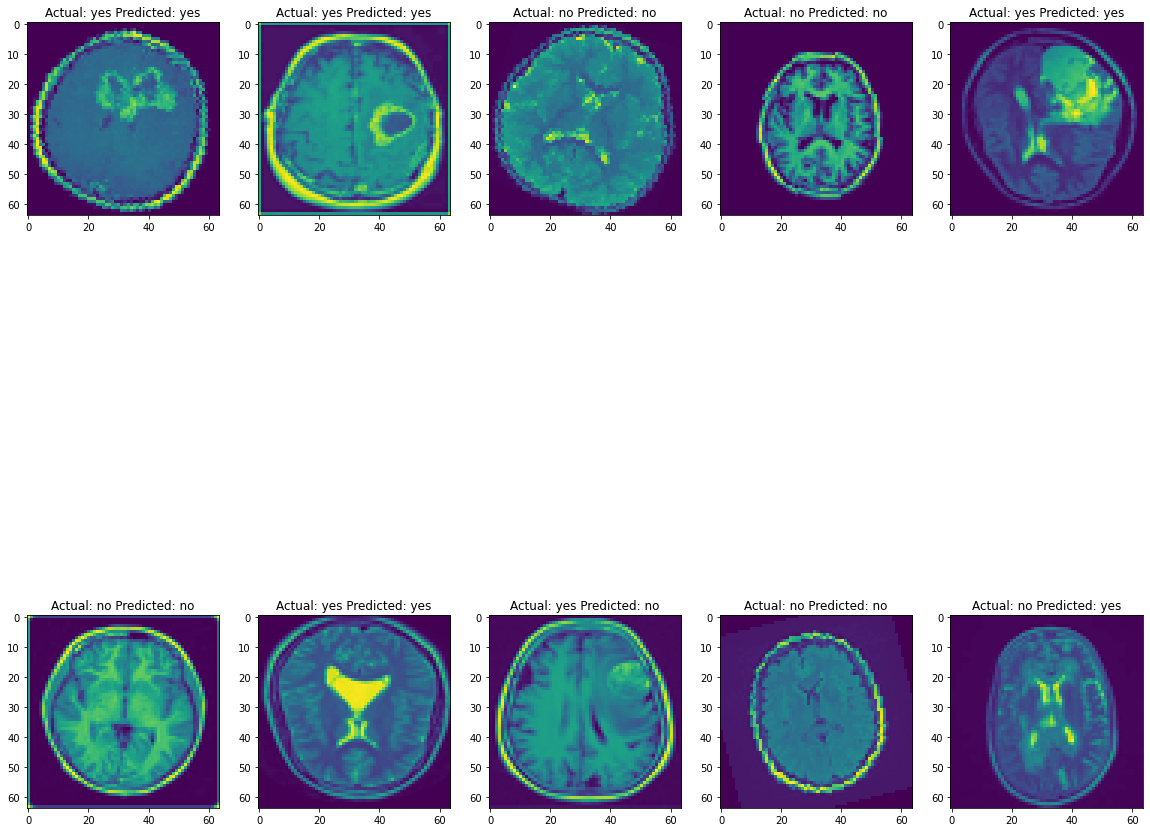

Time for inference: 1231.6897604465485


In [21]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
for i in range(10):
    img, label = next(iter_loader)
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(2,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

In [27]:
import time
start_time = time.time()

a_results = []

for ptr in a_ptrs:
    a_encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {a_encrypted_results}")
    a_plaintext_results = a_encrypted_results.reconstruct()
    print(f"plain text results: {a_plaintext_results}")
    a_results.append(a_plaintext_results)

end_time = time.time()
a_results

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 7695380480 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

TypeError: share() missing 1 required positional argument: 'session'